# 📊 Análise de Diversidade Beta

Análise da diferença na composição de espécies **ENTRE** amostras.

**Métricas:**
- Bray-Curtis
- Jaccard  
- UniFrac (weighted/unweighted)
- PCoA (Principal Coordinates Analysis)

In [1]:
import matplotlib
import shutil
import os

# Encontrar o local exato da cache
cache_dir = matplotlib.get_cachedir()
print(f"Localização da cache do Matplotlib: {cache_dir}")

if os.path.exists(cache_dir):
    try:
        # Apagar o diretório de cache
        shutil.rmtree(cache_dir)
        print("✅ Cache do Matplotlib limpa com sucesso!")
    except Exception as e:
        print(f"⚠️  Erro ao tentar apagar a cache: {e}")
        print("   Por favor, tente apagar o diretório acima manualmente.")
else:
    print("ℹ️  Diretório de cache não encontrado (provavelmente já está limpo).")

Localização da cache do Matplotlib: /home/gf307/.cache/matplotlib
✅ Cache do Matplotlib limpa com sucesso!


In [2]:
import sys
import matplotlib
import seaborn

print(f"Versão do Python: {sys.version}")
print(f"Caminho do Python: {sys.executable}")
print("---")
print(f"Versão do Matplotlib: {matplotlib.__version__}")
print(f"Versão do Seaborn: {seaborn.__version__}")

Versão do Python: 3.10.19 (main, Oct 21 2025, 16:43:05) [GCC 11.2.0]
Caminho do Python: /home/gf307/miniconda3/envs/yara/bin/python
---
Versão do Matplotlib: 3.5.3
Versão do Seaborn: 0.12.2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("✅ Bibliotecas importadas!")

Could not save font_manager cache [Errno 2] No such file or directory: '/home/gf307/.cache/matplotlib/fontlist-v390.json.matplotlib-lock'


✅ Bibliotecas importadas!


## 📊 1. Criar Dados de Exemplo - Tabela de Abundâncias

In [2]:
np.random.seed(42)

# 20 amostras, 50 ASVs
n_samples = 20
n_asvs = 50

sample_ids = [f"Amostra_{i+1}" for i in range(n_samples)]
asv_ids = [f"ASV_{i+1}" for i in range(n_asvs)]

# Grupos
grupos = np.array(['Controle'] * 10 + ['Tratamento'] * 10)

# Tabela de abundâncias
# Controle e Tratamento com composições diferentes
abundancias_controle = np.random.poisson(lam=50, size=(10, n_asvs))
abundancias_tratamento = np.random.poisson(lam=50, size=(10, n_asvs))

# Adicionar diferenças específicas
# ASVs 0-10 mais abundantes no controle
abundancias_controle[:, 0:10] *= 3

# ASVs 10-20 mais abundantes no tratamento
abundancias_tratamento[:, 10:20] *= 3

# Combinar
abundancias = np.vstack([abundancias_controle, abundancias_tratamento])

# DataFrame
df_abundancias = pd.DataFrame(
    abundancias,
    index=sample_ids,
    columns=asv_ids
)

# Adicionar metadados
df_metadata = pd.DataFrame({
    'Sample_ID': sample_ids,
    'Grupo': grupos
}).set_index('Sample_ID')

print(f"✅ Tabela de abundâncias: {df_abundancias.shape}")
print(f"   {n_samples} amostras × {n_asvs} ASVs")
print(f"\n📋 Primeiras 5 amostras e 5 ASVs:")
df_abundancias.iloc[:5, :5]

✅ Tabela de abundâncias: (20, 50)
   20 amostras × 50 ASVs

📋 Primeiras 5 amostras e 5 ASVs:


,ASV_1,ASV_2,ASV_3,ASV_4,ASV_5
Amostra_1,141,165,126,156,174
Amostra_2,138,132,144,120,195
Amostra_3,144,135,174,126,192
Amostra_4,147,192,129,117,117
Amostra_5,147,156,162,138,162


## 🧮 2. Calcular Matriz de Distâncias - Bray-Curtis

In [3]:
def bray_curtis_distance(u, v):
    """
    Calcula distância de Bray-Curtis entre dois vetores
    BC = Σ|ui - vi| / Σ(ui + vi)
    """
    numerator = np.sum(np.abs(u - v))
    denominator = np.sum(u + v)
    if denominator == 0:
        return 0
    return numerator / denominator

# Calcular matriz de distâncias
from scipy.spatial.distance import braycurtis

# Usar scipy (mais rápido)
distances = pdist(df_abundancias.values, metric='braycurtis')
distance_matrix = squareform(distances)

# Criar DataFrame
df_distances = pd.DataFrame(
    distance_matrix,
    index=sample_ids,
    columns=sample_ids
)

print("✅ Matriz de distâncias Bray-Curtis calculada!")
print(f"\n📊 Estatísticas das distâncias:")
print(f"   Mínima: {distances.min():.3f}")
print(f"   Máxima: {distances.max():.3f}")
print(f"   Média: {distances.mean():.3f}")
print(f"\n🔍 Primeiras 5×5 amostras:")
df_distances.iloc[:5, :5]

✅ Matriz de distâncias Bray-Curtis calculada!

📊 Estatísticas das distâncias:
   Mínima: 0.058
   Máxima: 0.341
   Média: 0.208

🔍 Primeiras 5×5 amostras:


,Amostra_1,Amostra_2,Amostra_3,Amostra_4,Amostra_5
Amostra_1,0.000000,0.087879,0.078530,0.089796,0.080143
Amostra_2,0.087879,0.000000,0.076617,0.097007,0.087600
Amostra_3,0.078530,0.076617,0.000000,0.098882,0.077978
Amostra_4,0.089796,0.097007,0.098882,0.000000,0.089216
Amostra_5,0.080143,0.087600,0.077978,0.089216,0.000000


## 🗺️ 3. PCoA (Principal Coordinates Analysis)

In [4]:
# MDS = PCoA quando metric=True
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(distance_matrix)

# DataFrame com coordenadas
df_pcoa = pd.DataFrame({
    'PC1': coords[:, 0],
    'PC2': coords[:, 1],
    'Grupo': grupos,
    'Sample_ID': sample_ids
})

print("✅ PCoA calculado!")
df_pcoa.head()

✅ PCoA calculado!


,PC1,PC2,Grupo,Sample_ID
0,0.133732,-0.084502,Controle,Amostra_1
1,0.053542,-0.164419,Controle,Amostra_2
2,0.085152,-0.139698,Controle,Amostra_3
3,0.155858,-0.055266,Controle,Amostra_4
4,0.145997,-0.102361,Controle,Amostra_5


## 📈 4. Visualizar PCoA

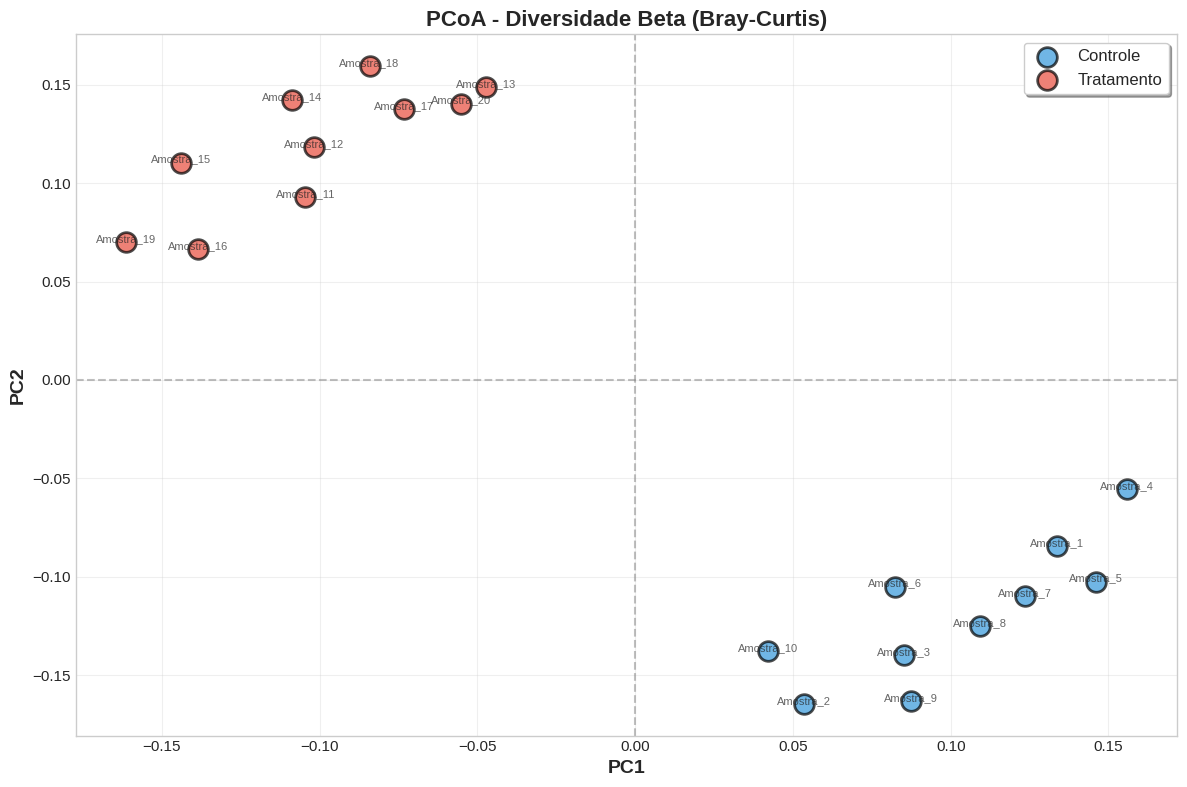

✅ Gráfico PCoA salvo!


In [5]:
fig, ax = plt.subplots(figsize=(12, 8))

# Cores por grupo
colors = {'Controle': '#3498db', 'Tratamento': '#e74c3c'}

for grupo in df_pcoa['Grupo'].unique():
    subset = df_pcoa[df_pcoa['Grupo'] == grupo]
    ax.scatter(
        subset['PC1'],
        subset['PC2'],
        label=grupo,
        s=200,
        alpha=0.7,
        edgecolors='black',
        linewidth=2,
        color=colors[grupo]
    )
    
    # Adicionar labels
    for idx, row in subset.iterrows():
        ax.annotate(
            row['Sample_ID'],
            (row['PC1'], row['PC2']),
            fontsize=8,
            alpha=0.7,
            ha='center'
        )

ax.set_xlabel('PC1', fontsize=14, fontweight='bold')
ax.set_ylabel('PC2', fontsize=14, fontweight='bold')
ax.set_title('PCoA - Diversidade Beta (Bray-Curtis)', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, frameon=True, shadow=True)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../data/qiime2/pcoa_beta_diversity.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico PCoA salvo!")

## 🔥 5. Heatmap de Distâncias

/home/gf307/miniconda3/envs/yara/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/gf307/miniconda3/envs/yara/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


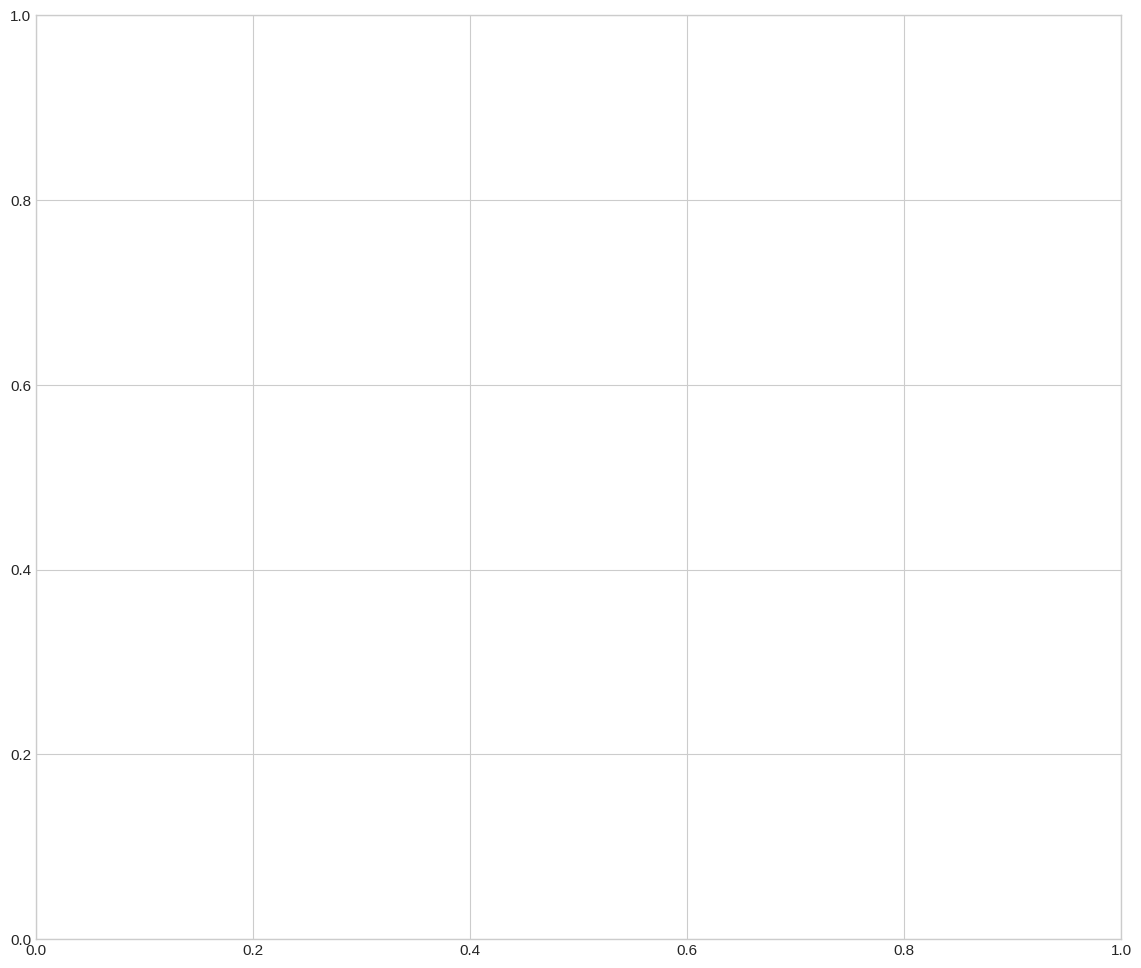

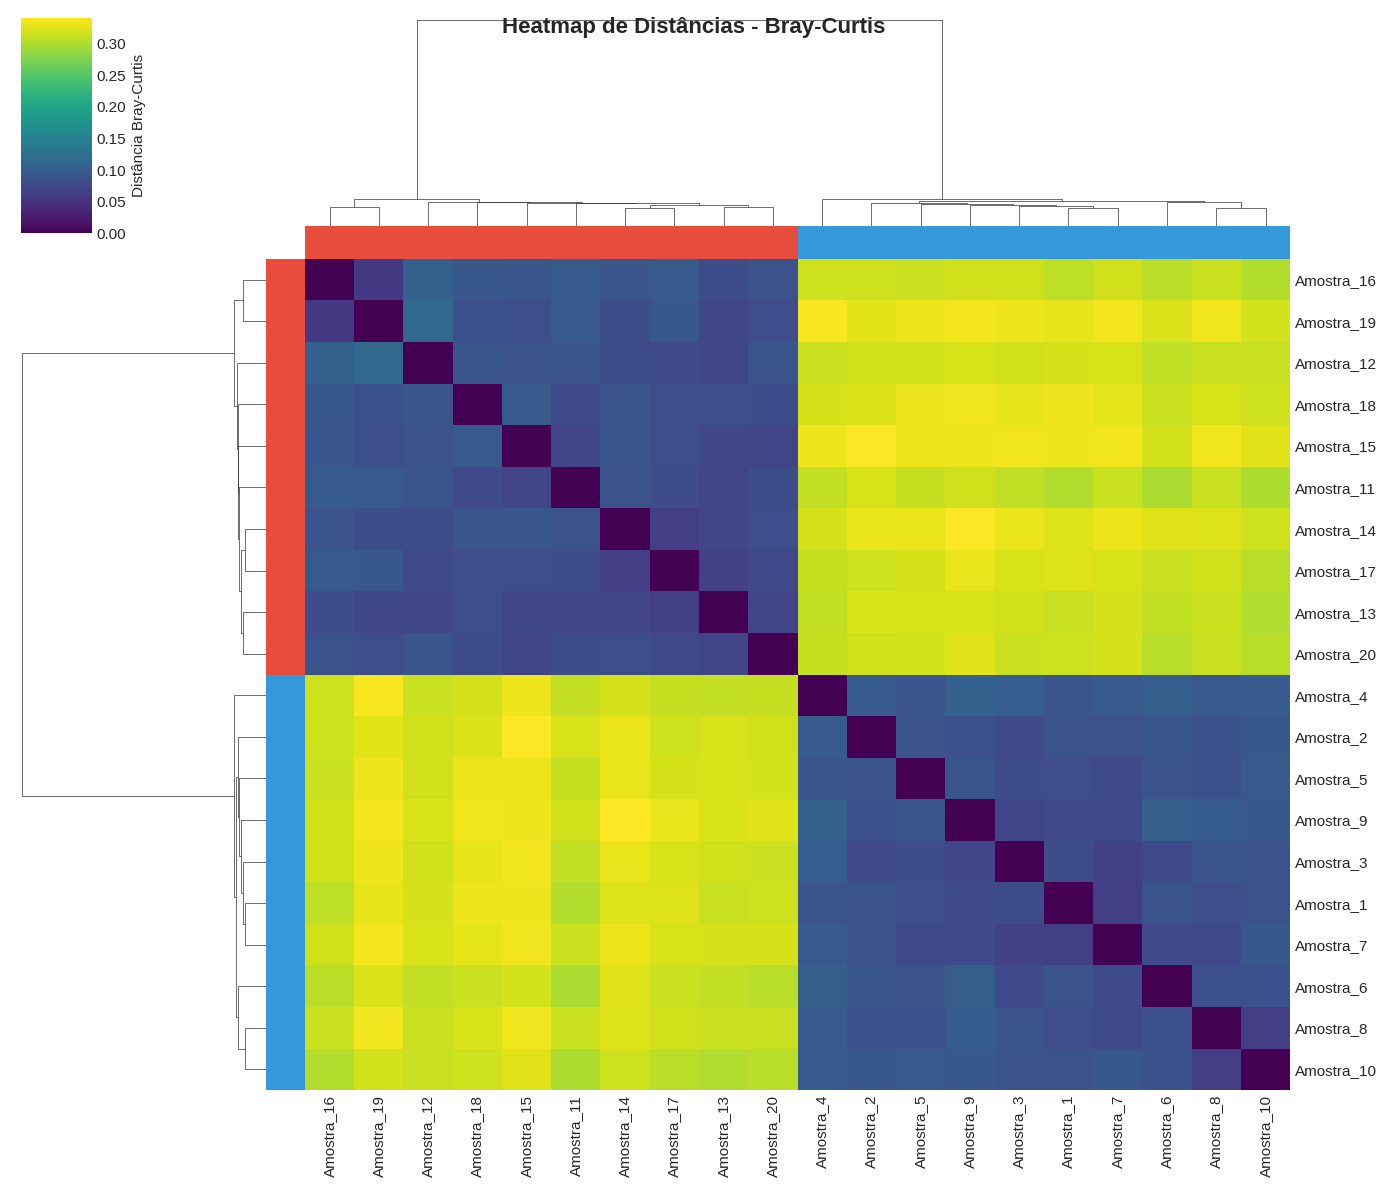

✅ Heatmap salvo!


In [6]:
fig, ax = plt.subplots(figsize=(14, 12))

# Adicionar cores de grupo nas laterais
grupo_colors = [colors[g] for g in grupos]

sns.clustermap(
    df_distances,
    cmap='viridis',
    figsize=(14, 12),
    row_colors=grupo_colors,
    col_colors=grupo_colors,
    cbar_kws={'label': 'Distância Bray-Curtis'}
)

plt.suptitle('Heatmap de Distâncias - Bray-Curtis', y=0.98, fontsize=16, fontweight='bold')
plt.savefig('../data/qiime2/heatmap_distances.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Heatmap salvo!")

## 🧪 6. PERMANOVA - Teste Estatístico

In [7]:
def permanova_simple(distance_matrix, groups, n_permutations=999):
    """
    PERMANOVA simplificado (apenas 2 grupos)
    Testa se há diferença significativa entre grupos
    """
    # Calcular F estatístico observado
    def calculate_f_stat(dist_mat, grps):
        unique_groups = np.unique(grps)
        n = len(grps)
        
        # Total sum of squares
        tss = np.sum(dist_mat ** 2) / (2 * n)
        
        # Within-group sum of squares
        wss = 0
        for group in unique_groups:
            group_indices = np.where(grps == group)[0]
            n_g = len(group_indices)
            if n_g > 1:
                group_dists = dist_mat[np.ix_(group_indices, group_indices)]
                wss += np.sum(group_dists ** 2) / (2 * n_g)
        
        # Between-group sum of squares
        bss = tss - wss
        
        # F-statistic
        df_between = len(unique_groups) - 1
        df_within = n - len(unique_groups)
        
        f_stat = (bss / df_between) / (wss / df_within)
        return f_stat
    
    # F observado
    f_obs = calculate_f_stat(distance_matrix, groups)
    
    # Permutações
    f_perms = []
    for _ in range(n_permutations):
        perm_groups = np.random.permutation(groups)
        f_perms.append(calculate_f_stat(distance_matrix, perm_groups))
    
    # P-valor
    p_value = (np.sum(np.array(f_perms) >= f_obs) + 1) / (n_permutations + 1)
    
    return f_obs, p_value

# Executar PERMANOVA
f_stat, p_value = permanova_simple(distance_matrix, grupos, n_permutations=999)

print("🧪 PERMANOVA - Teste de Diferença entre Grupos")
print("="*60)
print(f"F-statistic: {f_stat:.4f}")
print(f"P-valor: {p_value:.4f}")
print()

if p_value < 0.05:
    print("✅ DIFERENÇA SIGNIFICATIVA entre grupos (p < 0.05)")
    print("   As comunidades microbianas são DIFERENTES!")
else:
    print("❌ Sem diferença significativa (p >= 0.05)")
    print("   As comunidades microbianas são SIMILARES!")

🧪 PERMANOVA - Teste de Diferença entre Grupos
F-statistic: 134.3450
P-valor: 0.0010

✅ DIFERENÇA SIGNIFICATIVA entre grupos (p < 0.05)
   As comunidades microbianas são DIFERENTES!


## 📊 7. Distâncias Intra vs Inter-grupo

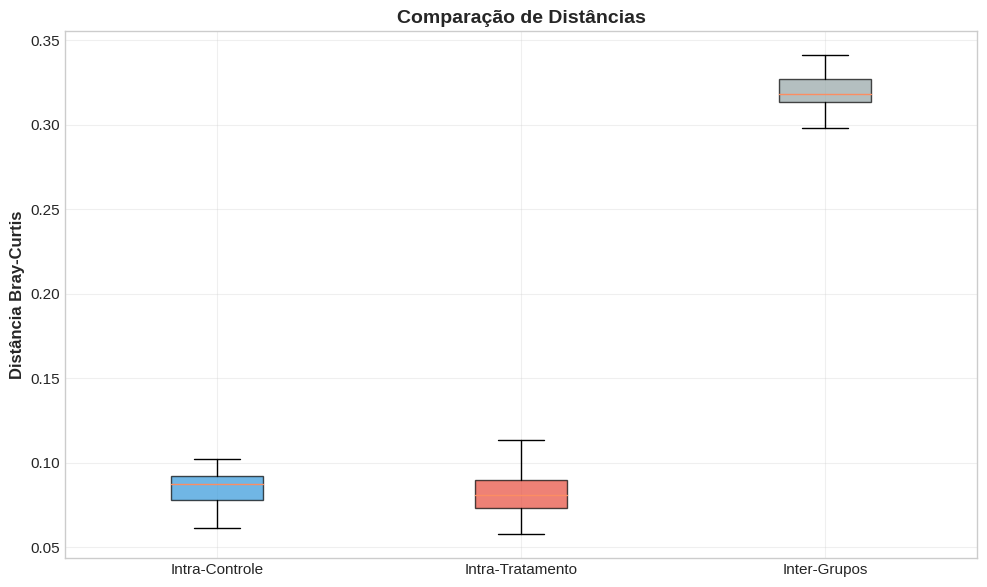

📊 Estatísticas:
   Intra-Controle: 0.086 ± 0.010
   Intra-Tratamento: 0.082 ± 0.011
   Inter-Grupos: 0.320 ± 0.010

🧪 Mann-Whitney U test:
   P-valor: 0.0000
   ✅ Distâncias inter-grupo SIGNIFICATIVAMENTE maiores!


In [8]:
# Extrair distâncias intra e inter-grupo
intra_controle = []
intra_tratamento = []
inter_grupos = []

for i in range(n_samples):
    for j in range(i+1, n_samples):
        dist = distance_matrix[i, j]
        
        if grupos[i] == grupos[j]:
            if grupos[i] == 'Controle':
                intra_controle.append(dist)
            else:
                intra_tratamento.append(dist)
        else:
            inter_grupos.append(dist)

# Visualizar
fig, ax = plt.subplots(figsize=(10, 6))

data_to_plot = [
    intra_controle,
    intra_tratamento,
    inter_grupos
]

bp = ax.boxplot(
    data_to_plot,
    labels=['Intra-Controle', 'Intra-Tratamento', 'Inter-Grupos'],
    patch_artist=True
)

colors = ['#3498db', '#e74c3c', '#95a5a6']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Distância Bray-Curtis', fontsize=12, fontweight='bold')
ax.set_title('Comparação de Distâncias', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/qiime2/distancias_comparacao.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Estatísticas:")
print(f"   Intra-Controle: {np.mean(intra_controle):.3f} ± {np.std(intra_controle):.3f}")
print(f"   Intra-Tratamento: {np.mean(intra_tratamento):.3f} ± {np.std(intra_tratamento):.3f}")
print(f"   Inter-Grupos: {np.mean(inter_grupos):.3f} ± {np.std(inter_grupos):.3f}")

# Teste estatístico
u_stat, p_val = mannwhitneyu(intra_controle + intra_tratamento, inter_grupos)
print(f"\n🧪 Mann-Whitney U test:")
print(f"   P-valor: {p_val:.4f}")
if p_val < 0.05:
    print("   ✅ Distâncias inter-grupo SIGNIFICATIVAMENTE maiores!")
else:
    print("   ❌ Sem diferença significativa")

## 💾 8. Salvar Resultados

In [9]:
# Salvar matriz de distâncias
df_distances.to_csv('../data/qiime2/distance_matrix_braycurtis.tsv', sep='\t')

# Salvar coordenadas PCoA
df_pcoa.to_csv('../data/qiime2/pcoa_coordinates.tsv', sep='\t', index=False)

# Salvar resultados estatísticos
resultados = {
    'PERMANOVA_F': f_stat,
    'PERMANOVA_p': p_value,
    'Distancia_Intra_Controle_Media': np.mean(intra_controle),
    'Distancia_Intra_Tratamento_Media': np.mean(intra_tratamento),
    'Distancia_Inter_Grupos_Media': np.mean(inter_grupos)
}

pd.DataFrame([resultados]).to_csv(
    '../data/qiime2/resultados_beta_diversity.tsv',
    sep='\t',
    index=False
)

print("✅ Todos os resultados salvos em data/qiime2/")
print("\n📁 Arquivos gerados:")
print("   - distance_matrix_braycurtis.tsv")
print("   - pcoa_coordinates.tsv")
print("   - resultados_beta_diversity.tsv")
print("   - pcoa_beta_diversity.png")
print("   - heatmap_distances.png")
print("   - distancias_comparacao.png")

✅ Todos os resultados salvos em data/qiime2/

📁 Arquivos gerados:
   - distance_matrix_braycurtis.tsv
   - pcoa_coordinates.tsv
   - resultados_beta_diversity.tsv
   - pcoa_beta_diversity.png
   - heatmap_distances.png
   - distancias_comparacao.png


## 🎯 Resumo

### ✅ Análises Realizadas:
1. Cálculo de distâncias Bray-Curtis
2. PCoA (visualização em 2D)
3. PERMANOVA (teste estatístico)
4. Comparação intra vs inter-grupo
5. Heatmap de distâncias

### 📊 Interpretação:
- **Amostras próximas no PCoA** = comunidades similares
- **Amostras distantes** = comunidades diferentes
- **PERMANOVA significativo** = grupos têm composições diferentes
- **Distâncias inter > intra** = grupos bem separados